In [3]:
import pandas as pd
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


## Dataset

In [4]:
start = "2022-01-01"
end = "2022-12-31"
df = yf.download('BTC-USD', start = start, end = end)

[*********************100%***********************]  1 of 1 completed


## EDA

In [5]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-01,46311.746094,47827.312500,46288.484375,47686.812500,47686.812500,24582667004
2022-01-02,47680.925781,47881.406250,46856.937500,47345.218750,47345.218750,27951569547
2022-01-03,47343.542969,47510.726562,45835.964844,46458.117188,46458.117188,33071628362
2022-01-04,46458.851562,47406.546875,45752.464844,45897.574219,45897.574219,42494677905
2022-01-05,45899.359375,46929.046875,42798.222656,43569.003906,43569.003906,36851084859


In [6]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-26,16842.250000,16920.123047,16812.369141,16919.804688,16919.804688,11886957804
2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828,16717.173828,15748580239
2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,16552.572266,17005713920
2022-12-29,16552.322266,16651.755859,16508.683594,16642.341797,16642.341797,14472237479
2022-12-30,16641.330078,16643.427734,16408.474609,16602.585938,16602.585938,15929162910


In [7]:
# Cut Close column
close = df[["Close"]]

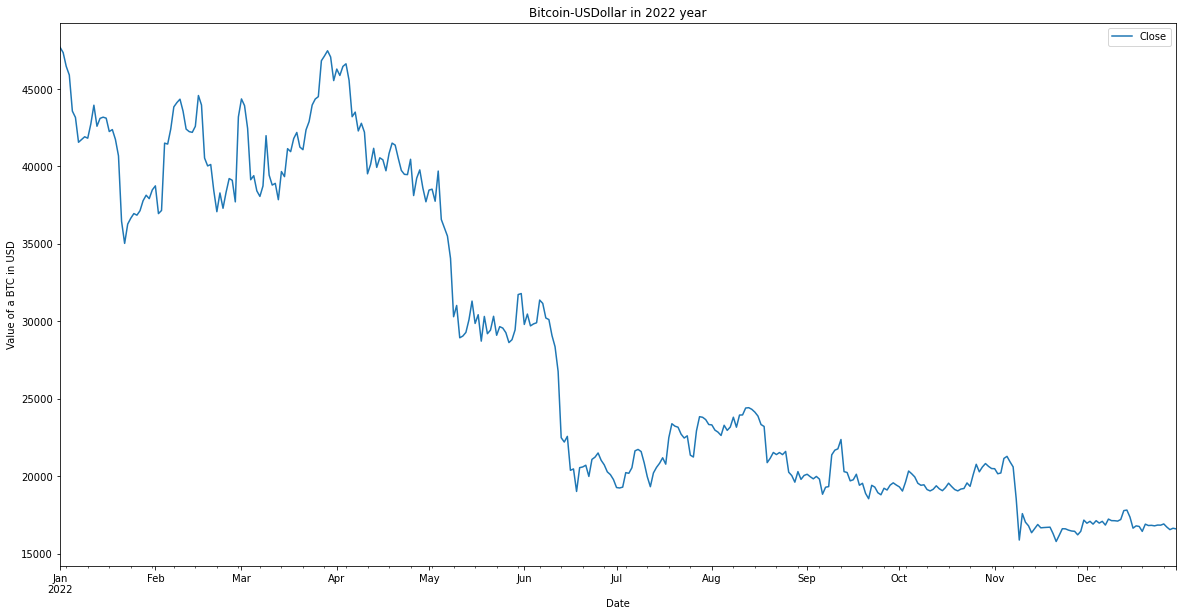

In [8]:
close.plot(y = "Close", title = "Bitcoin-USDollar in 2022 year", ylabel = "Value of a BTC in USD", figsize = (20,10))
plt.show()

## Stationary?

In [16]:
# It's clear from the above plot that data is non-stationary
# But always we can double check it with adfuller test
result_adfuller = adfuller(close)
pvalue = result_adfuller[1]
print(pvalue)
if pvalue < 0.05:
    print("stationary")
else:
    print("non-stationary")

0.4986177250880943
non-stationary


### diff(1) is stationary

In [15]:
result_adfuller = adfuller(close.diff(1).dropna())
pvalue = result_adfuller[1]
print(result_adfuller)
if pvalue < 0.05:
    print("stationary")
else:
    print("non-stationary")

(-18.89425350169882, 0.0, 0, 362, {'1%': -3.448544133483233, '5%': -2.8695574079525565, '10%': -2.5710411593052713}, 5760.929174756656)
stationary


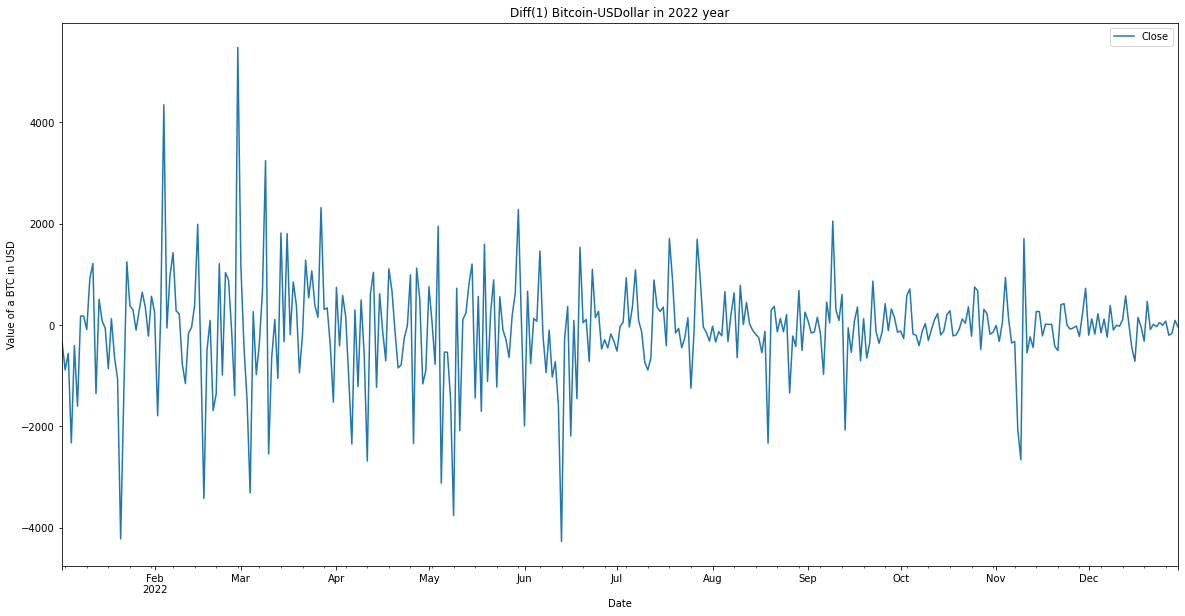

In [17]:
close.diff(1).dropna().plot(y = "Close", title = "Diff(1) Bitcoin-USDollar in 2022 year", ylabel = "Value of a BTC in USD", figsize = (20,10))
plt.show()